In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

Using TensorFlow backend.


In [11]:
#Testing if the video_id can be parsed
# tr = list(tf.python_io.tf_record_iterator('preprocessed_data/bal_spotgun_subset.tfrecord'))
# tf_example = tf.train.Example.FromString(tr[0])
# tf_example.features.feature['video_id'].bytes_list.value[0].decode()

test_records = list(tf.python_io.tf_record_iterator('../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord'))
print(len(test_records))
tf_seq_example = tf.train.SequenceExample.FromString(test_records[1])
example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
print(example_label)

584
[427, 430]


In [13]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord):
    max_len=10
    records = list(tf.python_io.tf_record_iterator(tfrecord))
    rec_len = len(records)
    print(rec_len)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size 
    j = 0

    gun_labels = [426,427,428,429,430,431]
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            gun_bin = any((True for x in example_label if x in gun_labels))
            y.append(gun_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, y

In [17]:
import itertools
batch_size = 32
val_gen = data_generator(batch_size,'../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord')
val = list(itertools.islice(val_gen,229//32))
X = [d[0] for d in val]
y = [d[1] for d in val]
X = np.concatenate(X)
y = np.concatenate(y)
print(len(X))
print(len(y))

584
224
224


In [75]:
# from keras.models import load_model
# m1 = load_model('Models/SingleLayerNN_loss=MeanLogarithmicError3_100Epochs.h5')
# p1 = m1.predict(X)
# score1 = m1.evaluate(X, y, verbose=1)
# print("%s: %.2f%%" % (m1.metrics_names[1], score1[1]*100))
# print("score is an array of size",len(score1))

# print(p1)

In [76]:
# from keras.models import load_model
# m2 = load_model('Models/SingleLayerNN__Loss=BinaryCE_100Epochs.h5')
# p2 = m2.predict(X)
# score2 = m2.evaluate(X, y, verbose=1)
# print("%s: %.2f%%" % (m2.metrics_names[1], score2[1]*100))
# print("score is an array of size",len(score2))

In [19]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

In [39]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
m3 = load_model('Models/LogisticRegression_BinaryCE_Adam_lr0.1_50-Epochs.h5')
p3 = m3.predict(X)
score3 = m3.evaluate(X, y, verbose=1)
print("%s: %.2f%%" % (m3.metrics_names[1], score3[1]*100))
print("score is an array:",len(score3))

# print(p3.dtype)

tn, fp, fn, tp = confusion_matrix(y, p3).ravel()
print("true negative = ", tn)
print("true positive=", tp)
print("false positive",fp)
print("false negative",fn)

print("Recall = ", tp/(tp+fn))
print("Precision = ", tp/(tp+fp))
print("miss rate = ", fn/(fn+tp))
print("specifity", tn/(tn+fp))

224/224 [==============================] - 1s 2ms/step
acc: 79.46%
score is an array: 2
true negative =  77
true positive= 101
false positive 23
false negative 23
Recall =  0.8145161290322581
Precision =  0.8145161290322581
miss rate =  0.18548387096774194
specifity 0.77


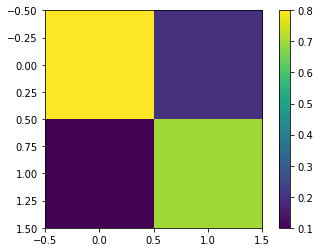

In [38]:
plt.imshow([[0.8,0.2],[0.1,0.7]])
plt.colorbar()
plt.savefig('results/training_results/CM_LR_BinCE_Adam_lr0.1_pochs70.png', dpi = 300)

In [27]:
# def plot_confusion_matrix(y_true, y_pred, classes,
#                           normalize=False,
#                           title=None,
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     fig, ax = plt.subplots()
#     im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
#     # We want to show all ticks...
#     ax.set(xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label')

#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

#     # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
#     return ax


# np.set_printoptions(precision=2)


224/224 [==============================] - 2s 9ms/step
acc: 87.95%
score is an array: 2
[0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
length of predictions: 224
length of p4 224
true negative =  83
true positive= 114
false positive 17
false negative 10
Recall =  0.9193548387096774
Precision =  0.8702290076335878
miss rate =  0.08064516129032258
specifity 0.83


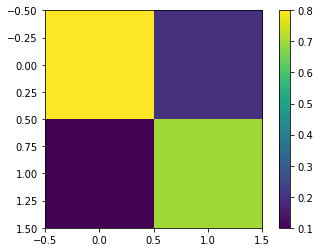

In [78]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
m4 = load_model('Models/1LayerLSTM__Loss=BinCE_40Epochs_highestacc.h5')
p4 = m4.predict(X)
score4 = m4.evaluate(X, y, verbose=1)
print("%s: %.2f%%" % (m4.metrics_names[1], score4[1]*100))
print("score is an array:",len(score4))

p4_predictions=[]
for i in p4:
    if i >=0.5:
        p4_predictions.append(1)
    else:
        p4_predictions.append(0)
        
print(p4_predictions)
print("length of predictions:", len(p4_predictions))
print("length of p4", len(p4))

tn, fp, fn, tp = confusion_matrix(y, p4_predictions).ravel()
print("true negative = ", tn)
print("true positive=", tp)
print("false positive",fp)
print("false negative",fn)

print("Recall = ", tp/(tp+fn))
print("Precision = ", tp/(tp+fp))
print("miss rate = ", fn/(fn+tp))
print("specifity", tn/(tn+fp))
plt.imshow([[0.8,0.2],[0.1,0.7]])
plt.colorbar()
plt.savefig('results/training_results/CM_LSTM1_BinCE_Adam_lr0.001_40EP.png', dpi = 300)
          

In [72]:
from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(y,p1)
# fpr2, tpr2, thresholds2 = roc_curve(y,p2)
fpr3, tpr3, thresholds3 = roc_curve(y,p3)
fpr4,tpr4, thresholds4 = roc_curve(y,p4)

In [73]:
from sklearn.metrics import auc
# auc_NN1_meanlog = auc(fpr, tpr)
# auc_NN1_binaryCE = auc(fpr2,tpr2)
auc_LR_binaryCE = auc(fpr3,tpr3)
auc_LSTM_binaryCE = auc(fpr4, tpr4)

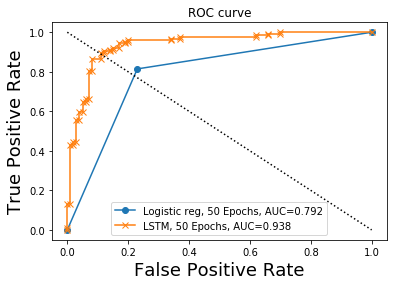

In [74]:
# plt.plot(fpr,tpr, 'o-', label='1 Layer NN-100 nodes, Loss = Mean_log_error, AUC={:.3f}'.format(auc_NN1_meanlog))
# plt.plot(fpr2,tpr2, 'x-', label='1 Layer NN-100 nodes, Binary Cross Entropy, AUC={:.3f}'.format(auc_NN1_binaryCE))
plt.plot(fpr3,tpr3, 'o-', label='Logistic reg, 50 Epochs, AUC={:.3f}'.format(auc_LR_binaryCE))
plt.plot(fpr4,tpr4, 'x-', label = 'LSTM, 50 Epochs, AUC={:.3f}'.format(auc_LSTM_binaryCE))

plt.plot([0,1],[1,0],'k:')
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
plt.title('ROC curve')
plt.legend(loc='best')
# plt.figure()
plt.savefig('ROC curves_LR_LSTM', dpi = 300)

In [ ]:
print(y)

In [ ]:
print(p3)

In [ ]:
fpr3


In [ ]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, probs)

In [ ]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, probs)

In [ ]:
# calculate precision-recall AUC
auc = auc(recall, precision)

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
prec_NN1log, recall_NN1log, th_prec= precision_recall_curve(y,p1)
print("precision:",prec_NN1log)
print("recall:", recall_NN1log)

f1_NN1log = f1_score(y, p1)
auc_pr = auc(recall_NN1log, precision_NN1log)
# calculate average precision score
ap = average_precision_score(y, p1)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()
# fpr2, tpr2, thresholds2 = roc_curve(y,p2)
# fpr3, tpr3, thresholds3 = roc_curve(y,p3)

precision: [0.25       0.45783133 0.46341463 0.4691358  0.48101266 0.48717949
 0.49350649 0.48684211 0.49333333 0.5        0.51388889 0.52112676
 0.52857143 0.53623188 0.52941176 0.53731343 0.54545455 0.55384615
 0.5625     0.57142857 0.58064516 0.59016393 0.6        0.61016949
 0.62068966 0.63157895 0.625      0.63636364 0.64814815 0.66037736
 0.67307692 0.68627451 0.68       0.69387755 0.6875     0.68085106
 0.67391304 0.66666667 0.68181818 0.69767442 0.69047619 0.70731707
 0.725      0.71794872 0.73684211 0.72972973 0.75       0.77142857
 0.76470588 0.75757576 0.75       0.76666667 0.75862069 0.78571429
 0.77777778 0.76       1.        ]
recall: [1.         0.67857143 0.67857143 0.67857143 0.67857143 0.67857143
 0.67857143 0.66071429 0.66071429 0.66071429 0.66071429 0.66071429
 0.66071429 0.66071429 0.64285714 0.64285714 0.64285714 0.64285714
 0.64285714 0.64285714 0.64285714 0.64285714 0.64285714 0.64285714
 0.64285714 0.64285714 0.625      0.625      0.625      0.625
 0.625      0

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord', 1-CV_frac, 1)

rec_len = 

lstm3_h = lstm3_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100, 
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=0, callbacks=[TQDMNotebookCallback()])